Workflow v5
- Get section tops
- Run UQ with variations for x, y, z
- Get entropy map
- Get UQ reals tops

In [1]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs
import functions.pre_processing as pre_pro

# executable
print(sys.executable)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/home/stefan/coding/notebooks/env/bin/python


#### Init geo_model

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


#### Data

In [3]:
# meta
geo_model_extent = [0,800,0,800,0,1000]
section = {
    'p1': [0, 400],
    'p2': [800, 400],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# Orientaions
orientaions_input_data = pd.read_csv('./data/model2_orientations.csv')
orientations_original_df = orientaions_input_data[
    ['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

# SurfacePoints
surface_points_input_data = pd.read_csv('./data/own_model_surface_points.csv')
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']
surface_points_original_df['param1'] = 10

#### Setup model

In [4]:
# %%timeit ~ 200ms
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent,
        section=section,
        series_df=series_df,
        surfaces_df=surfaces_df,
        surface_points_original_df=surface_points_original_df,
        orientations_original_df=orientations_original_df
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


#### Calculate model

In [5]:
# %%timeit  ~ 120ms 
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


#### Postprocessing

In [6]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

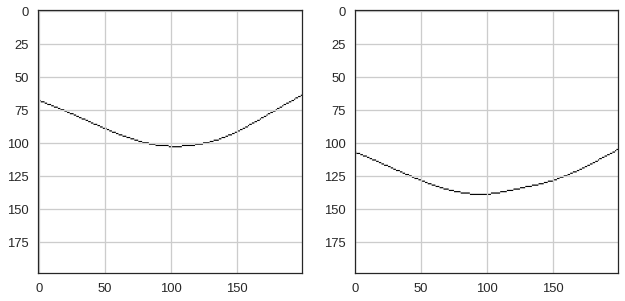

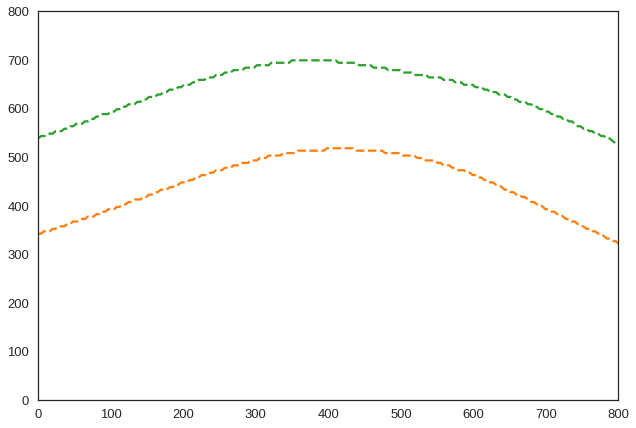

In [7]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()

post_pro.plot_tops(tops_dict, 'small_model_tops', 0, 800, 0, 800)

plt.show()

In [8]:
mapping_object = real_setup.creat_mapping_object(
    series_df=series_df,
    surfaces_df=surfaces_df
)

In [ ]:
entropy_map = uq_runs.calulate_entropy_map(
    geo_model=geo_model,
    n_realization=10,
    surface_points_original_df=surface_points_original_df,
    orientations_original_df=orientations_original_df,
    section=section,
    mapping_object=mapping_object
)

Realization: 0
HOTFIX in gempy/core/gempy_api.py 328
Realization: 1


In [ ]:
plt.imshow(entropy_map.T, cmap='viridis')
plt.axis('off')
plt.show()